In [1]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
# sns.set_theme()
from data.dataset import NERDataset
import random

In [2]:
base = 'data/conll03'
sourceName = f'{base}/eng.train.src'
targetName = f'{base}/eng.train.trg'
gloveFile = f'{base}/trimmed.300d.Cased.txt'
symbFile = f'{base}/sym.glove'
testSrc = 'data/conll03/eng.testb.src'
testTrg = 'data/conll03/eng.testb.trg'
data = NERDataset(sourceName, targetName, gloveFile, symbFile)

In [3]:
def printStats(src, unk = data.wordIdx['<unk>']):
    numToks = sum(len(w) for w, c, t in data)
    numUnk = sum(list(w).count(unk) for w, c, t in data)
    print(src, numToks, numUnk)

In [4]:
printStats('train')

testSrc = 'data/conll03/eng.testa.src'
testTrg = 'data/conll03/eng.testa.trg'
data.readTestFile(testSrc, testTrg)
printStats('testa')

testSrc = 'data/conll03/eng.testb.src'
testTrg = 'data/conll03/eng.testb.trg'
data.readTestFile(testSrc, testTrg)
printStats('testb')

data = NERDataset(sourceName, targetName, gloveFile, symbFile)

train 203621 3910
testa 51362 4542
testb 46435 5693


In [5]:
def countTags(filename):
    count = {}
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip().split()
            for tag in line:
                if tag not in count:
                    count[tag] = 1
                else:
                    count[tag] += 1
    return count

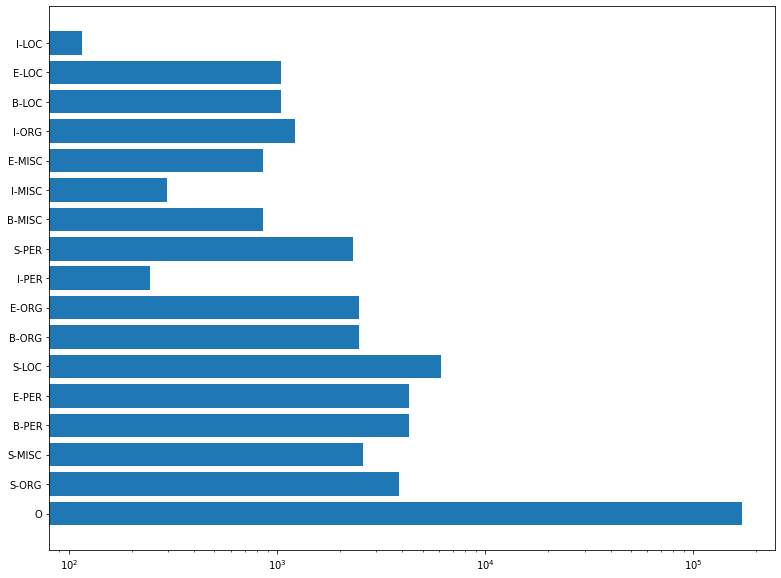

In [6]:
counts = countTags(targetName)
x, y = zip(*counts.items())
fig, ax = plt.subplots(figsize=(13,10))
ax.barh(x, y)
plt.xscale('log')

Text(0, 0.5, 'Frequencies')

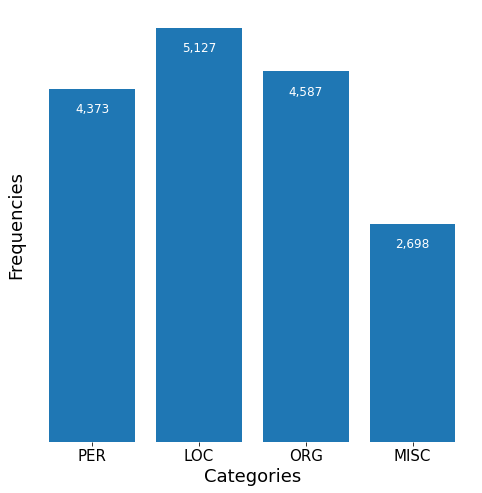

In [7]:
categories  = 'PER LOC ORG MISC'.split()
catIdx = {k:i for i, k in enumerate(categories)}
frequencies = [0 for c in categories]
for i in range(len(data)):
    tar = [data.tags[t][2:] for t in data[i][2] if data.tags[t]!='O' ]
    tar = list(set(tar))
    for t in tar:
        frequencies[catIdx[t]] += 1

fig, ax = plt.subplots(figsize=(8,8))
ax.bar(categories, frequencies)
for px, py in zip(categories, frequencies):
    ax.text(px, py - 300, f"{py:,}", color='white', ha="center", fontsize=12)
#     ax.text(px, 400, px, color='white', ha="center", fontsize=12)
for k in ax.spines:
    ax.spines[k].set_visible(False)
ax.set_yticks([])
plt.xticks(fontsize=15)
# ax.set_title("Histogram of Named Entities", fontsize=18)
ax.set_xlabel("Categories", fontsize=18)
ax.set_ylabel("Frequencies", fontsize=18)

## Random examples of a class

In [8]:
targets = {k:[] for k in data.tags}
for i in range(len(data)):
    for w, c, t in zip(*data[i]):
        targets[data.tags[t]].append(data.words[w])

In [9]:
for key in targets:
    l = random.choices(targets[key], k=10)
    print(key.ljust(8), *l)

B-LOC    The Sri Costa KANSAS South Old <unk> San University Las
B-MISC   World Iraqi TOUR 1,000 NATIONAL F.A. Grand Sri HAMLET Grand
B-ORG    PF Tallinna SAN Philadelphia Status F.C. Federal Baltika Ministry LOS
B-PER    Antonio Gerald Chris Steffi Prince Clarence Karin I.K. Justice Joakim
E-LOC    Hospital Freeport Africa Republic States Africa YORK Forest Beach Republic
E-MISC   Open African Cup LEAGUE Index India Korean OPEN <unk> Afghan
E-ORG    Doetinchem Desk Paulo Villa <unk> Beersheva CSU India Royals <unk>
E-PER    Martin Clinton Azharuddin Kiernan Basuki Carling <unk> Hubner Russell Bois
I-LOC    Maria School DE York Matthews COLLECTIVE Football Senora East of
I-MISC   no Series OF Grand ' : Drug World World Spongiform
I-ORG    for KB Food for England Conservation Brothers Information Labour Trade
I-PER    Haj van der der Jahan Khaleda Maya Golf De immi
O        difficult met The carmaker of group , preferred pardoned out
S-LOC    germany China Britain U.S. Ramallah U.S. U.S

## Examples of sentences with MISC tags

In [10]:
for i in torch.randperm(len(data)):
    found = any(["MISC" in data.tags[t]
                     for w, c, t in zip(*data[i]) ])
    if found:
        for w, c, t in zip(*data[i]):
            print(data.tags[t].ljust(8), data.words[w])
            found = True
        break

O        9.
B-PER    Rui
E-PER    Madeira
O        (
S-LOC    Portugal
O        )
B-MISC   Toyota
E-MISC   Celica
O        16:34


## Context matrix

In [11]:
cols  = 'PER LOC ORG MISC'.split()
frame = pd.DataFrame({c:[0]*len(cols) for c in cols}, index=cols)
for i in range(len(data)):
    tar = [data.tags[t][2:] for t in data[i][2] if data.tags[t]!='O' ]
    tar = list(set(tar))
    for i in tar:
        for j in tar:
            if i!=j:
                frame[i][j] += 1

In [12]:
frame

,PER,LOC,ORG,MISC
PER,0,2113,1168,918
LOC,2113,0,1133,1069
ORG,1168,1133,0,677
MISC,918,1069,677,0


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

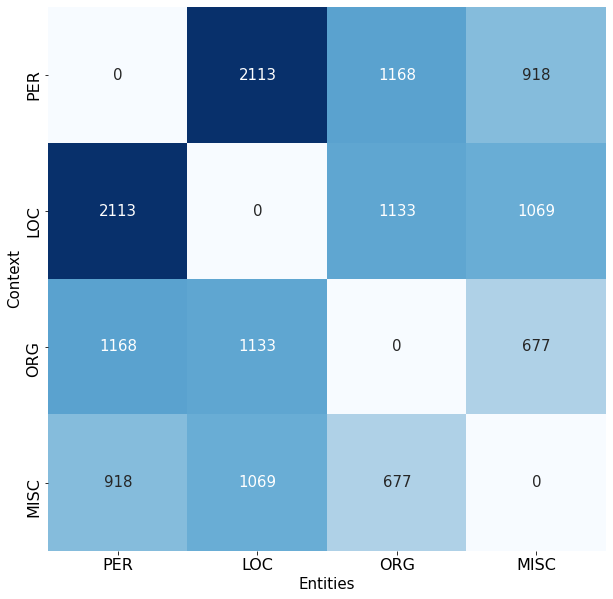

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(frame, annot=True, ax=ax, fmt='', cmap='Blues', annot_kws={"size": 15}, cbar=False)
ax.set_xlabel('Entities', fontsize=15)
ax.set_ylabel('Context', fontsize=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)